In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Загрузка данных

In [3]:
df = pd.read_parquet('data/transaction_fraud_data.parquet')
exchange_rates = pd.read_parquet('data/historical_currency_exchange.parquet')

print("Размер основного датасета:", df.shape)
print("Размер датасета с курсами:", exchange_rates.shape)
print("\nПервые строки основного датасета:")
df.head()

Размер основного датасета: (7483766, 23)
Размер датасета с курсами: (31, 12)

Первые строки основного датасета:


,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


Распаковка вложенной структуры last_hour_activity

In [4]:
last_hour_df = pd.json_normalize(df['last_hour_activity'])
df = pd.concat([df.drop('last_hour_activity', axis=1), last_hour_df], axis=1)

print("\nСтруктура данных после распаковки:\n")
df.info()


Структура данных после распаковки:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 27 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object    

## Базовая статистика
Распределение целевой переменной: Проверим баланс классов `is_fraud`, и посмотрим какая доля транзакций — мошеннические.

In [5]:
fraud_stats = df['is_fraud'].value_counts()
fraud_percentage = df['is_fraud'].mean() * 100
print(f"Всего транзакций: {len(df)}")
print(f"Мошеннических транзакций: {fraud_stats[True]} ({fraud_percentage:.2f}%)")
print(f"Легитимных транзакций: {fraud_stats[False]} ({100-fraud_percentage:.2f}%)")

Всего транзакций: 7483766
Мошеннических транзакций: 1494719 (19.97%)
Легитимных транзакций: 5989047 (80.03%)


**Вывод**: Мошенничество составляет около 20% всех транзакций, что является высоким уровнем риска

## Анализ категориальных признаков

Посмотрим распределение по категориям, чтобы понять какие категории транзакций преобладают.

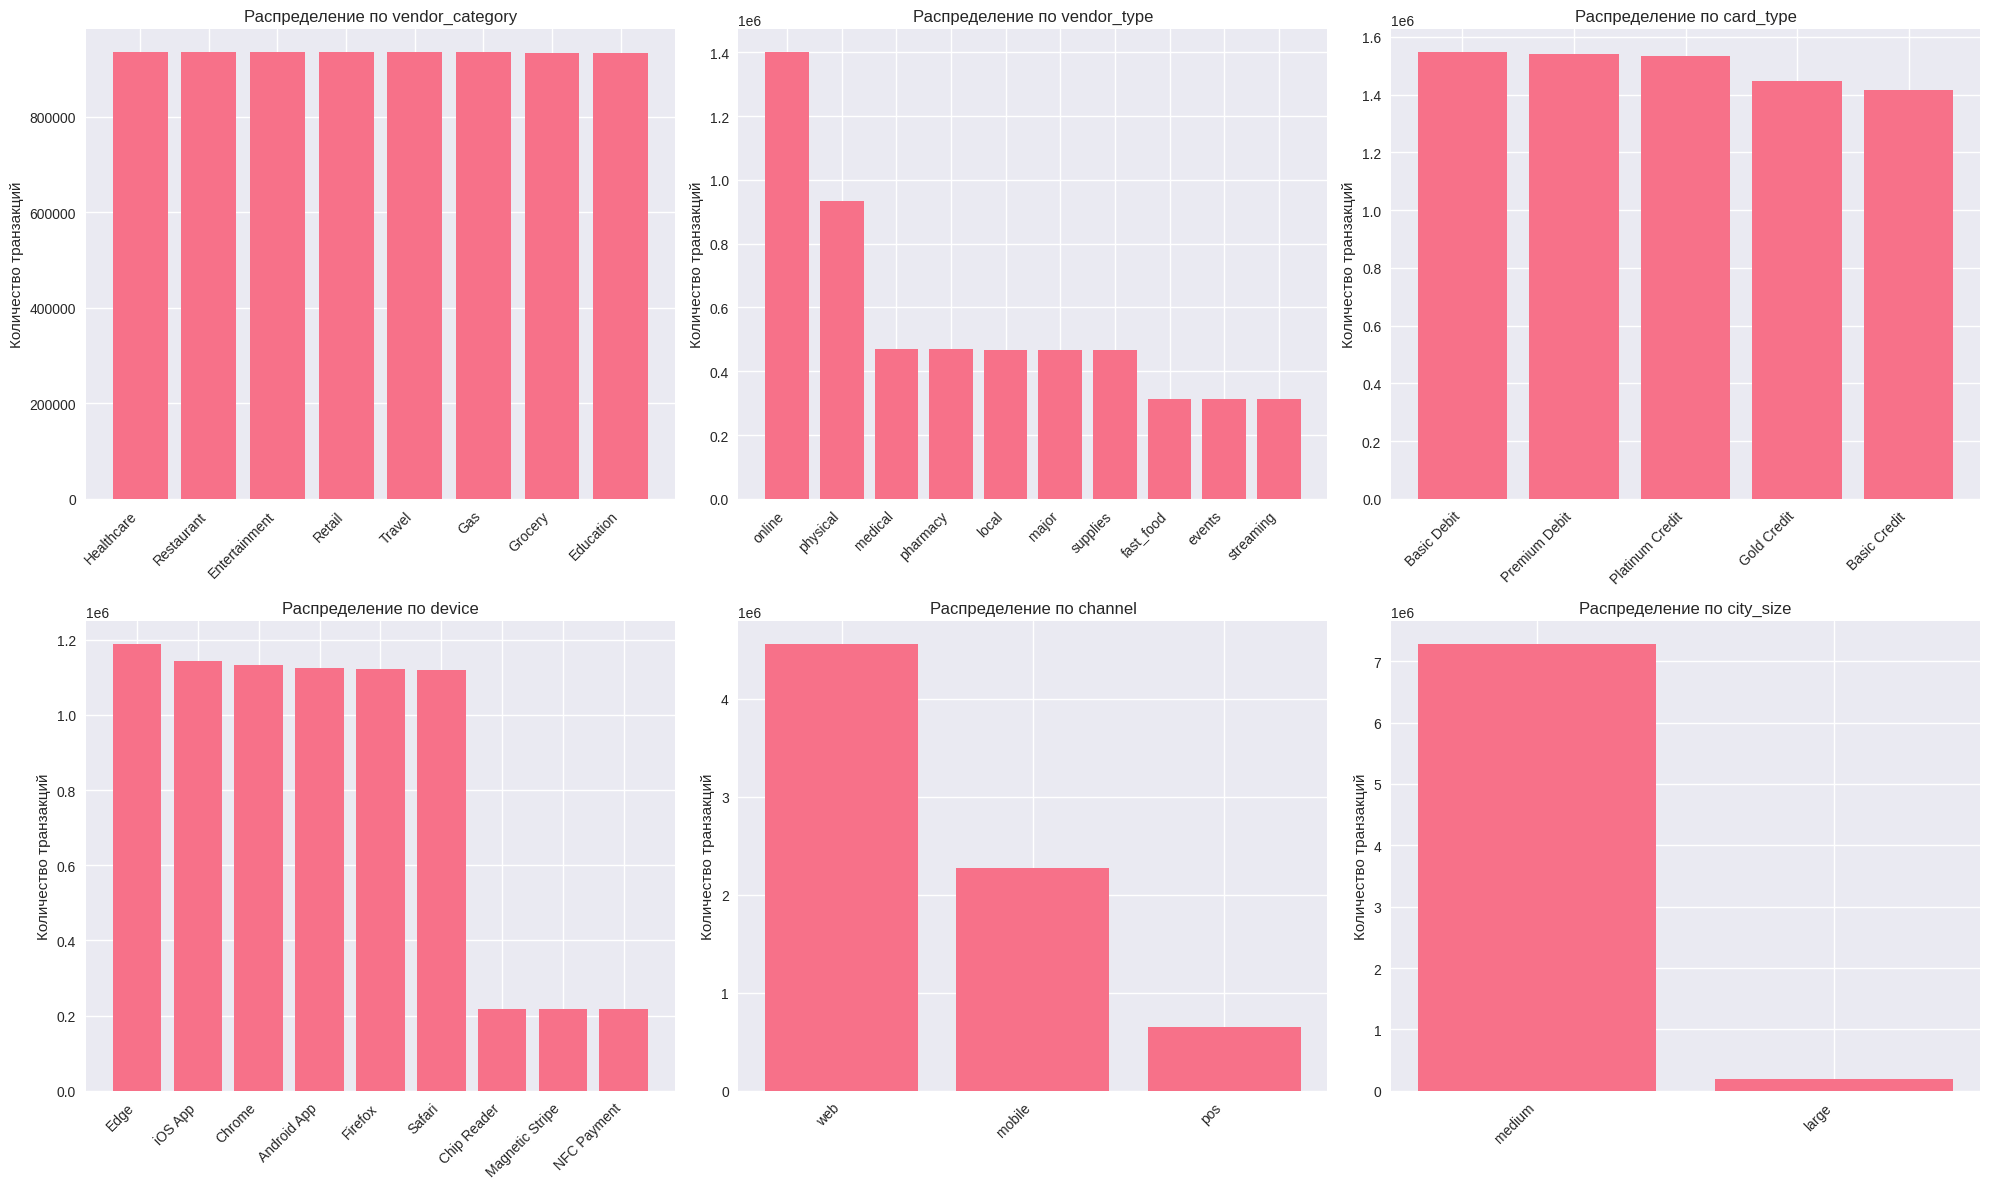

In [6]:
categorical_features = ['vendor_category', 'vendor_type', 'card_type', 'device', 'channel', 'city_size']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    if feature in df.columns:
        # Распределение по категориям
        top_categories = df[feature].value_counts().head(10)
        axes[i].bar(range(len(top_categories)), top_categories.values)
        axes[i].set_xticks(range(len(top_categories)))
        axes[i].set_xticklabels(top_categories.index, rotation=45, ha='right')
        axes[i].set_title(f'Распределение по {feature}')
        axes[i].set_ylabel('Количество транзакций')

plt.tight_layout()
plt.show()

Теперь посмотрим какие из категорий чаще всего связаны с мошенничеством.

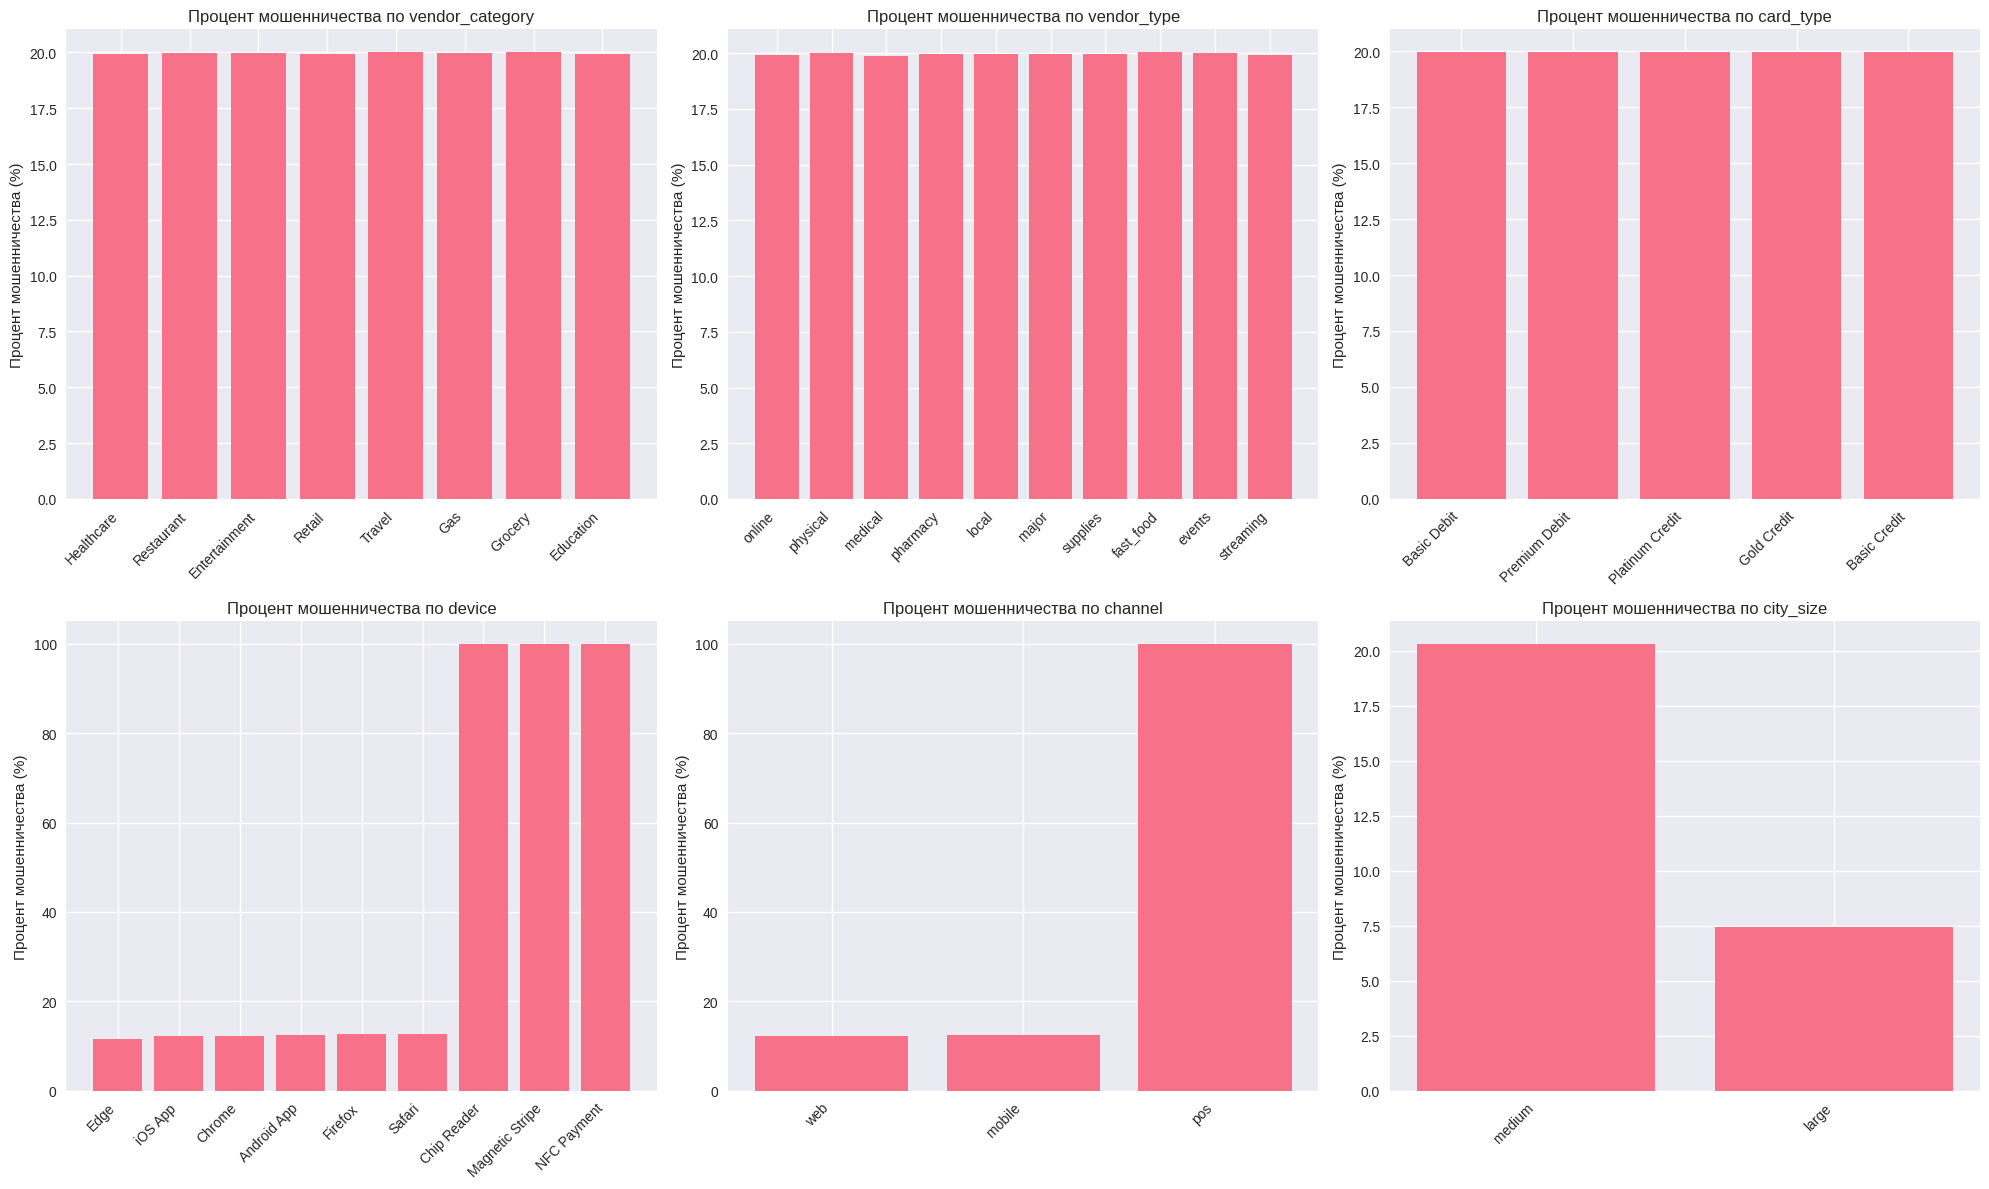

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    if feature in df.columns:
        fraud_rate = df.groupby(feature)['is_fraud'].agg(['count', 'sum', 'mean']).reset_index()
        fraud_rate = fraud_rate.nlargest(10, 'count')

        axes[i].bar(range(len(fraud_rate)), fraud_rate['mean'] * 100)
        axes[i].set_xticks(range(len(fraud_rate)))
        axes[i].set_xticklabels(fraud_rate[feature], rotation=45, ha='right')
        axes[i].set_title(f'Процент мошенничества по {feature}')
        axes[i].set_ylabel('Процент мошенничества (%)')

plt.tight_layout()
plt.show()

**Выводы**:

1. Топ-4 страны по количеству транзакций: `Nigeria, Brazil, Russia, Mexico`, также имеют самые высокие проценты мошенничества (от 35% до 38%). Эти регионы представляют собой ключевые центры как легитимной активности, так и мошенничества.
2. Низкий уровень мошенничества в развитых странах: `Singapore, France, UK, Canada, Japan, Germany, USA, Australia`, демонстрируют менее чем 10% мошеннических транзакций.
3. Все категории вендоров имеют примерно равное количество транзакций (от 800 000 до 900000). Процент мошенничества также распределен относительно равномерно (20% во всех категориях).
Следовательно, нет явного лидера среди категорий вендоров по частоте мошенничества.

4. Распределение по типам вендоров:
 - Тип online доминирует с 1.4 млн транзакций.
 - Другие типы (physical, medical, pharmacy, etc.) имеют значительно меньшее количество транзакций (300 000–600 000).

 Онлайн-транзакции являются наиболее распространенными и могут представлять собой высокорисковый канал из-за их доступности и анонимности.

5. Распределение транзакций по типам карт практически одинаковое (примерно 1.5 млн транзакций для каждого типа). Процент мошенничества также равномерен (20%).
Следовательно, нет значительных различий в уровне мошенничества между различными типами карт.


6. Chrome является самым популярным устройством для совершения транзакций. Высокий уровень мошенничества через Chip Reader и NFC Payment указывает на необходимость усиления контроля за этими устройствами.

7. Web и mobile — высокорисковые каналы, особенно мобильные устройства, где мошенничество составляет 20%. POS-канал значительно безопаснее.

8. Крупные города демонстрируют наибольшее количество транзакций, но средние города имеют более высокий уровень мошенничества.


## Анализ числовых признаков

Построим графики распределений числовых признаков, и проверим, есть ли аномально высокие значения. Применим логарифмическое преобразование для лучшей визуализации.

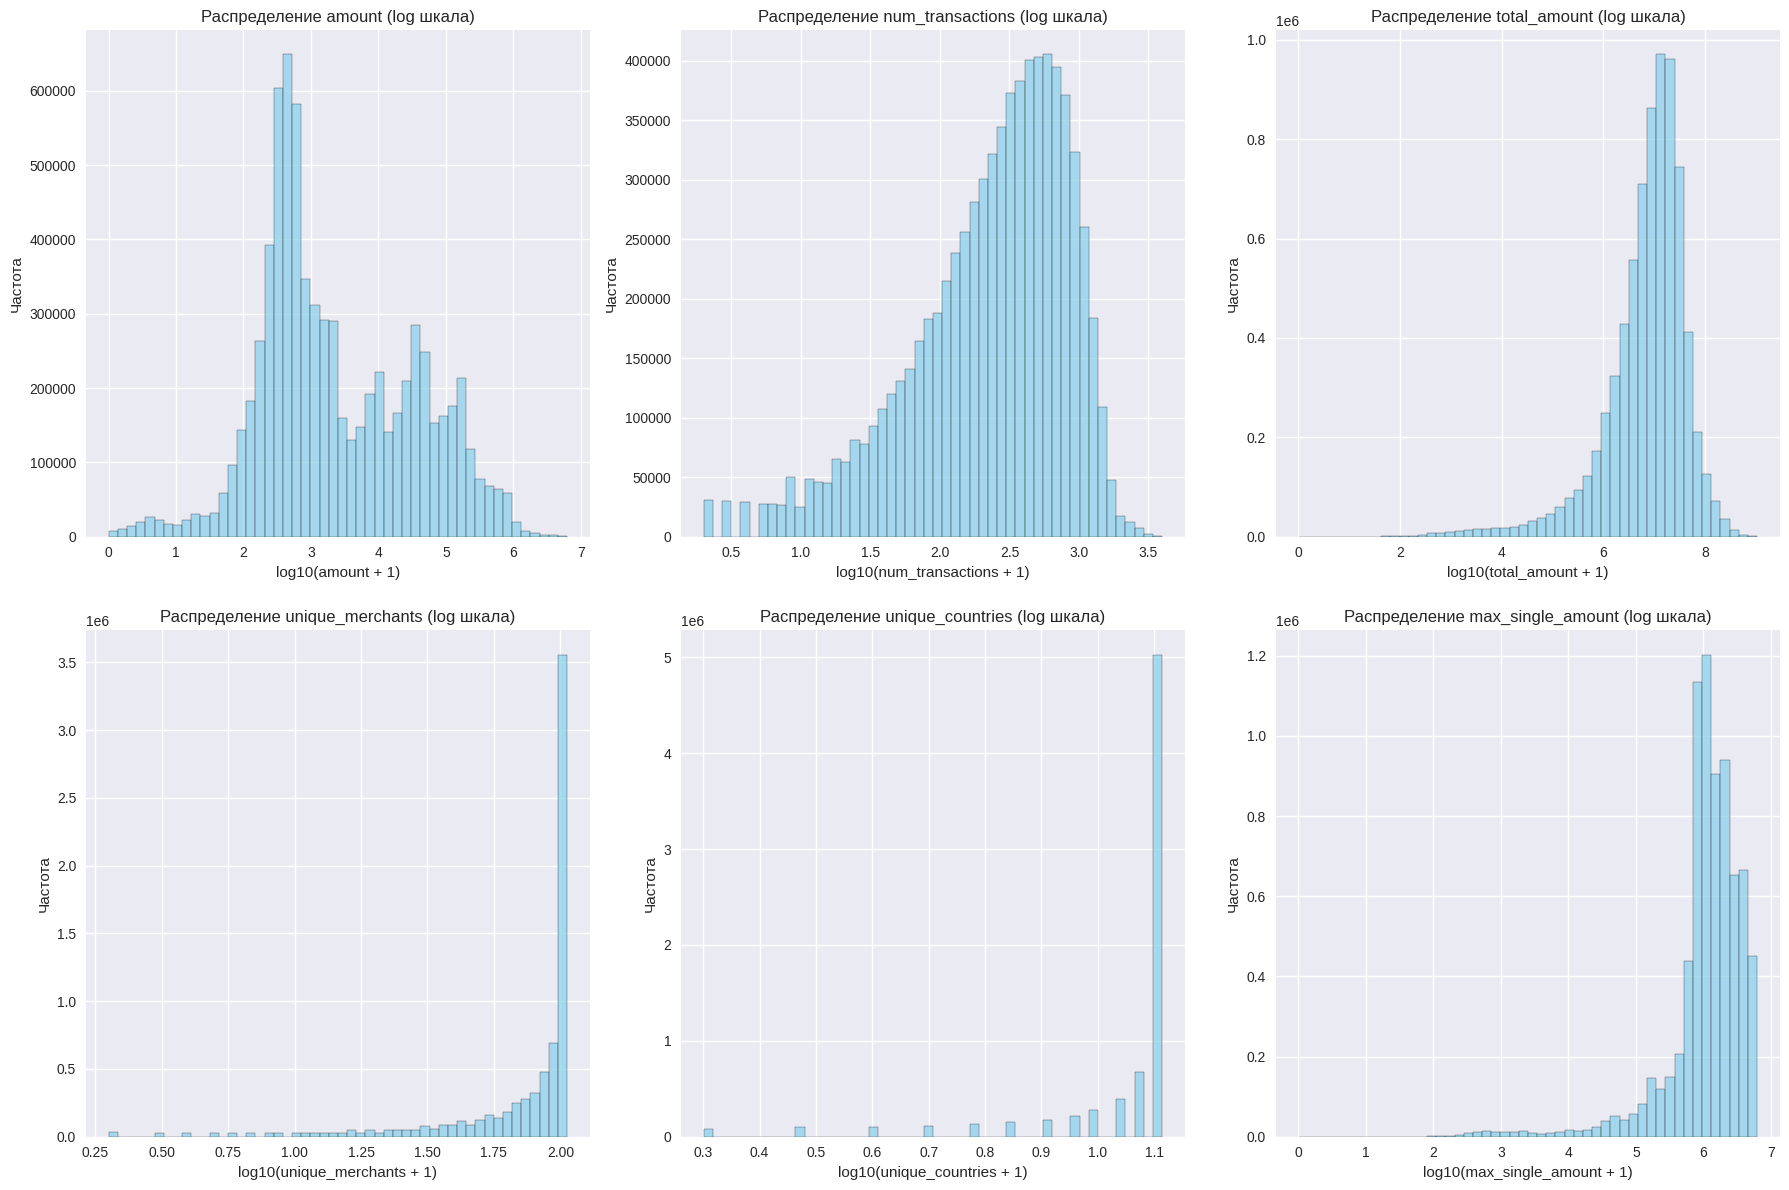

In [8]:
numeric_features = ['amount', 'num_transactions', 'total_amount', 'unique_merchants',
                   'unique_countries', 'max_single_amount']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    if feature in df.columns:
        non_zero_data = df[df[feature] > 0][feature]
        if len(non_zero_data) > 0:
            log_data = np.log10(non_zero_data + 1)
            axes[i].hist(log_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'Распределение {feature} (log шкала)')
            axes[i].set_xlabel(f'log10({feature} + 1)')
            axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Сравним суммы мошеннических и легитимных транзакций, чтобы понять какие признаки лучше всего разделяют мошенников и обычных клиентов и выявить конкретные числовые паттерны мошенничества.

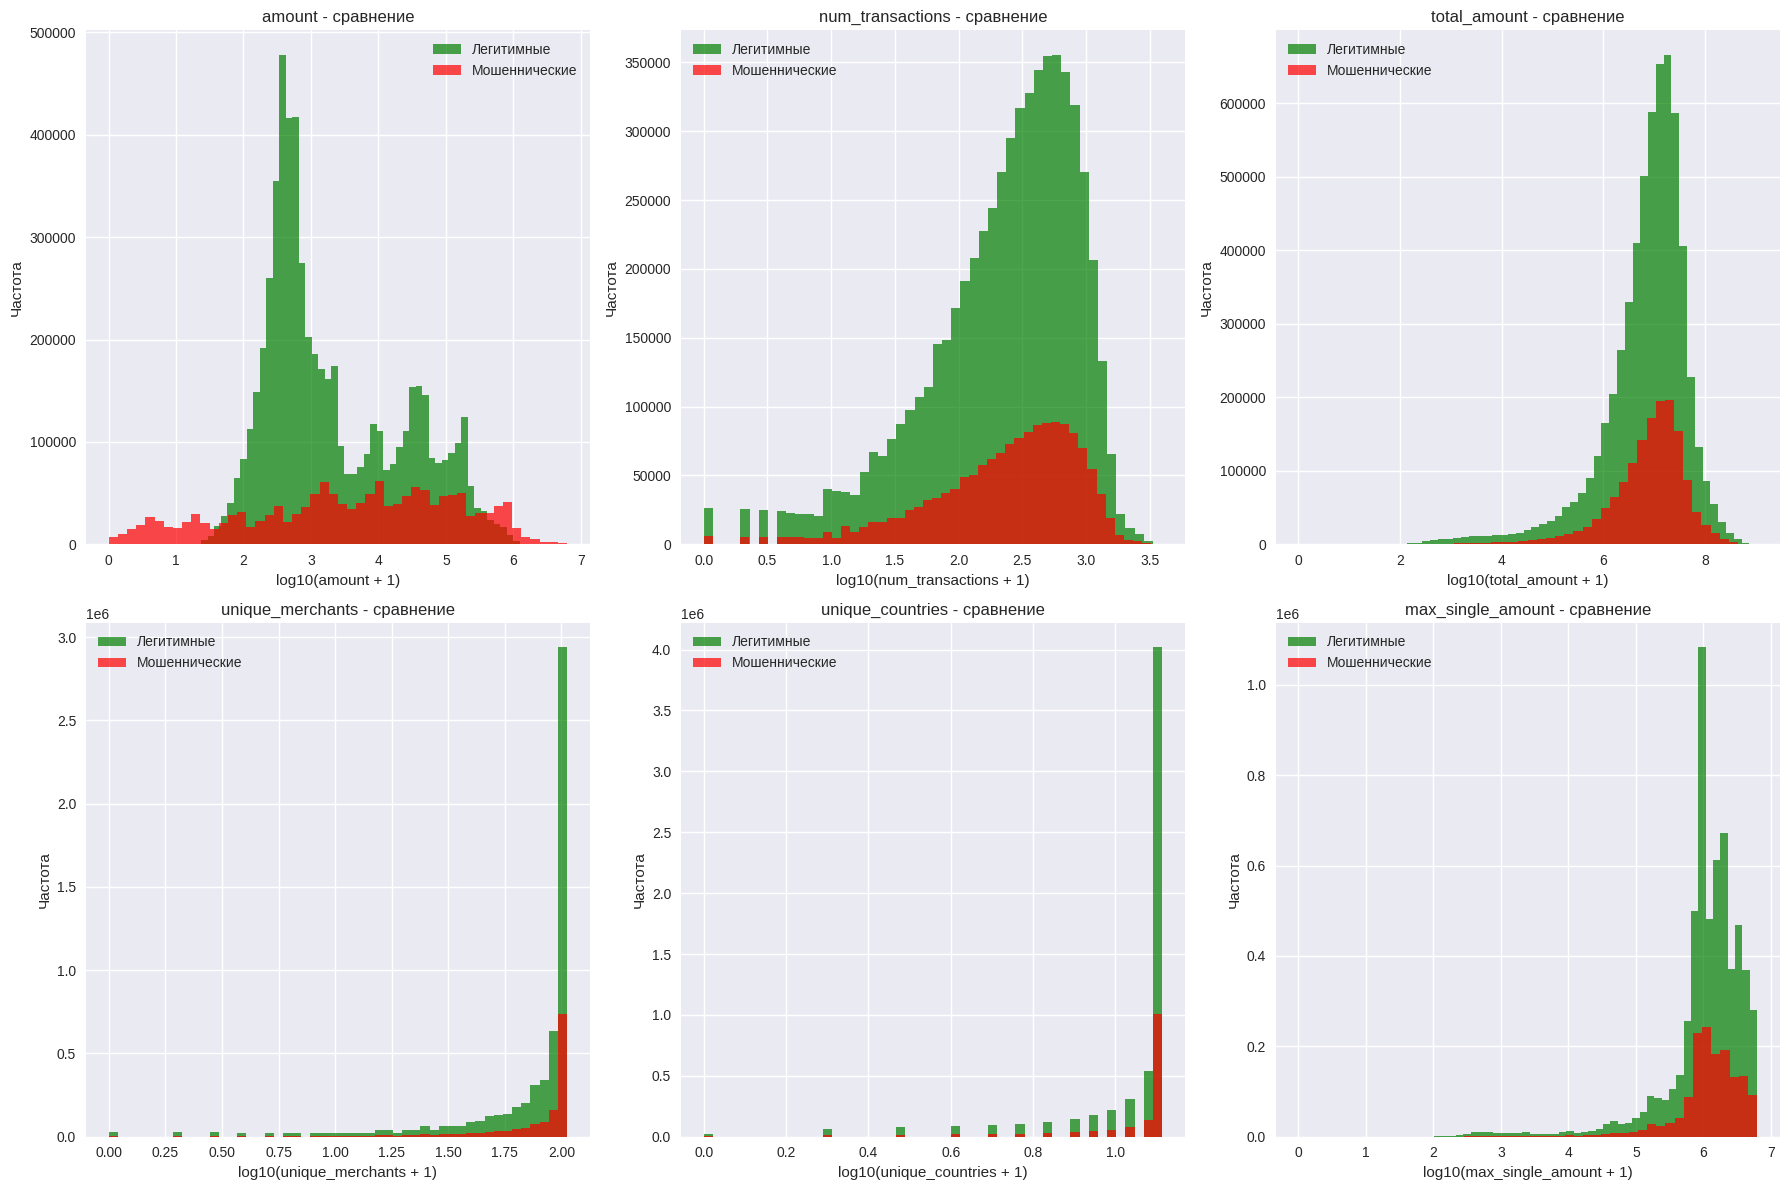

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(numeric_features[:6]):
    if feature in df.columns:
        legit = df[df['is_fraud'] == False][feature].dropna()
        fraud = df[df['is_fraud'] == True][feature].dropna()

        if len(legit) > 0 and len(fraud) > 0:
            axes[i].hist(np.log10(legit + 1), bins=50, alpha=0.7, label='Легитимные', color='green')
            axes[i].hist(np.log10(fraud + 1), bins=50, alpha=0.7, label='Мошеннические', color='red')
            axes[i].set_title(f'{feature} - сравнение')
            axes[i].set_xlabel(f'log10({feature} + 1)')
            axes[i].set_ylabel('Частота')
            axes[i].legend()

plt.tight_layout()
plt.show()

**Выводы**:

1. Сумма транзакций (amount): Распределение логарифмически нормальное, с большим количеством маленьких транзакций и длинным хвостом больших сумм. Мошеннические транзакции чаще имеют более высокие суммы.

2. Количество транзакций за последний час (num_transactions): Большинство клиентов совершают небольшое количество транзакций за час. Мошенники часто совершают больше транзакций за короткое время.

3. Общая сумма за последний час (total_amount): Распределение также логарифмическое, с преобладанием небольших сумм. Мошеннические транзакции характеризуются более высокой общей суммой.

4. Число уникальных продавцов (unique_merchants): Преобладают транзакции с одним продавцом. Мошенники чаще работают с несколькими продавцами.

5. Число уникальных стран (unique_countries): Большинство транзакций происходят в одной стране. Мошенники чаще совершают транзакции в нескольких странах.

6. Максимальная сумма одной транзакции (max_single_amount): Распределение логарифмическое, с преобладанием небольших сумм. Мошеннические транзакции имеют более высокие максимальные суммы.

Таким образом:

- *Высокая активность = подозрительно*: Мошенники часто совершают много транзакций за короткое время, что отличает их от обычных пользователей.
- *Большие суммы = повышенный риск*: Мошеннические транзакции чаще имеют более высокие значения amount и max_single_amount.

- *Географическая диверсификация = подозрительно*: Мошенники часто совершают транзакции в разных странах и с несколькими продавцами.

## Географический анализ

Построим распределение по странам, городам, размеру города.

Во-первых, посмотрим топ-10 стран по количеству транзакций.

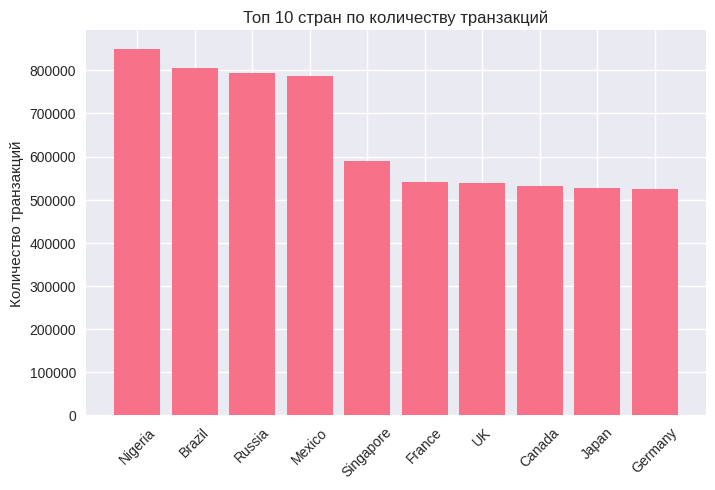

In [10]:
top_countries = df['country'].value_counts().head(10)
plt.figure(figsize=(8, 5))
plt.bar(range(len(top_countries)), top_countries.values)
plt.xticks(range(len(top_countries)), top_countries.index, rotation=45)
plt.title('Топ 10 стран по количеству транзакций')
plt.ylabel('Количество транзакций')
plt.show()

Во-вторых, процент мошенничества по странам.

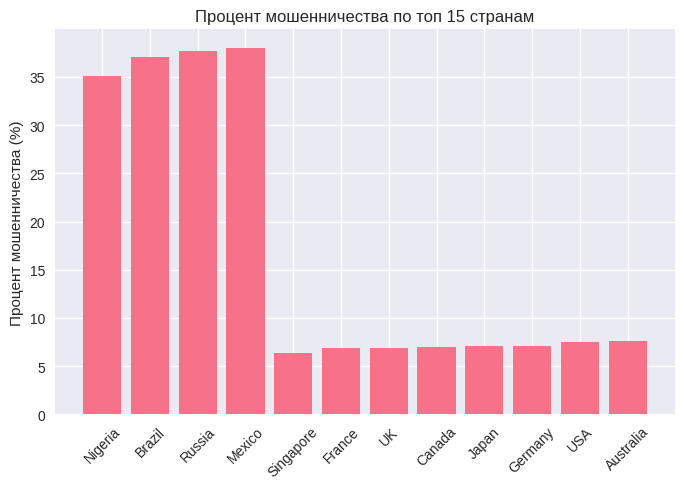

In [11]:
country_fraud = df.groupby('country')['is_fraud'].agg(['count', 'sum', 'mean']).reset_index()
country_fraud = country_fraud.nlargest(15, 'count')
plt.figure(figsize=(8, 5))
plt.bar(range(len(country_fraud)), country_fraud['mean'] * 100)
plt.xticks(range(len(country_fraud)), country_fraud['country'], rotation=45)
plt.title('Процент мошенничества по топ 15 странам')
plt.ylabel('Процент мошенничества (%)')
plt.show()

Теперь проведем анализ транзакций за границей.

In [12]:
print("\nАнализ транзакций за границей:")
border_stats = df.groupby('is_outside_home_country')['is_fraud'].agg(['count', 'sum', 'mean'])
print(border_stats)


Анализ транзакций за границей:
                           count      sum      mean
is_outside_home_country                            
False                    5073605   126343  0.024902
True                     2410161  1368376  0.567753


**Выводы:**

Африка и Латинская Америка требуют усиленного мониторинга из-за высокого уровня мошенничества. Для развитых стран можно использовать менее жесткие правила проверки. Транзакции за границей значительно опаснее.


## Анализ времени

Извлечем временные признаки. Построим распределение по часам и процент мошенничества по часам. Тем самым мы поймем когда больше всего транзакций и мошенничества, и, следовательно, усилить внимание в высокорисковые часы.

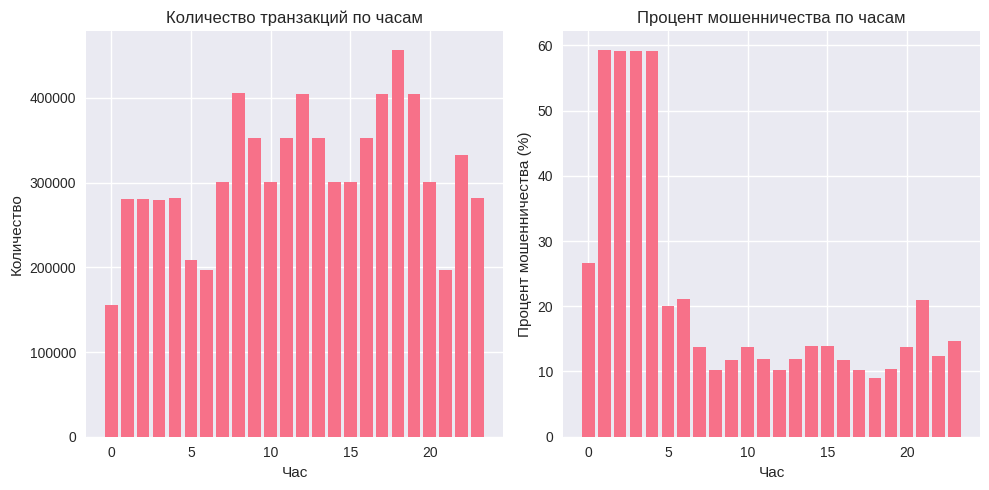

In [13]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['date'] = df['timestamp'].dt.date

hourly_fraud = df.groupby('hour')['is_fraud'].agg(['count', 'sum', 'mean'])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(hourly_fraud.index, hourly_fraud['count'])
plt.title('Количество транзакций по часам')
plt.xlabel('Час')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
plt.bar(hourly_fraud.index, hourly_fraud['mean'] * 100)
plt.title('Процент мошенничества по часам')
plt.xlabel('Час')
plt.ylabel('Процент мошенничества (%)')
plt.tight_layout()
plt.show()

Теперь то же самое построим по дням недели.

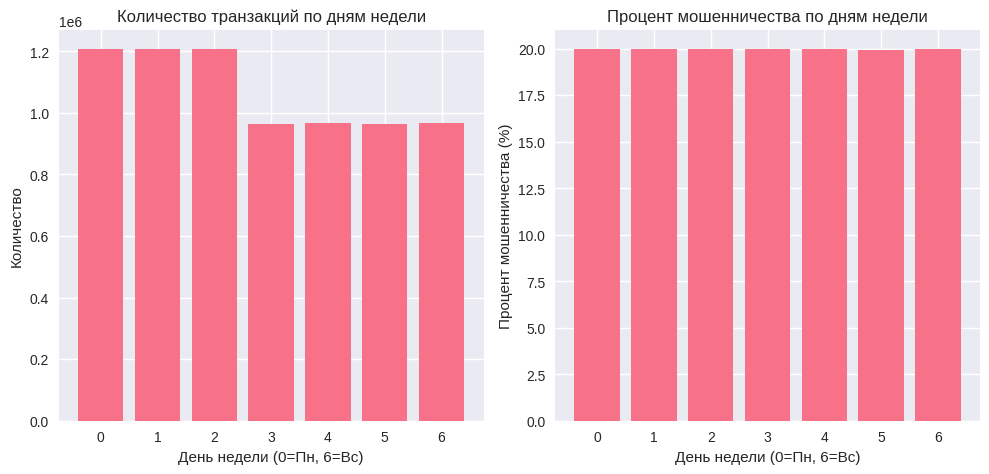

In [14]:
weekday_fraud = df.groupby('day_of_week')['is_fraud'].agg(['count', 'sum', 'mean'])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(weekday_fraud.index, weekday_fraud['count'])
plt.title('Количество транзакций по дням недели')
plt.xlabel('День недели (0=Пн, 6=Вс)')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
plt.bar(weekday_fraud.index, weekday_fraud['mean'] * 100)
plt.title('Процент мошенничества по дням недели')
plt.xlabel('День недели (0=Пн, 6=Вс)')
plt.ylabel('Процент мошенничества (%)')
plt.tight_layout()
plt.show()

**Выводы:**

Дневное время характеризуется как наиболее рискованным периодом для мошенничества. Хотя ночью меньше транзакций, мошенники все равно остаются активными. Мошенничество происходит равномерно в течение недели, что указывает на постоянную активность злоумышленников.

## Анализ поведенческих паттернов

Построим корреляционную матрицу для числовых признаков.

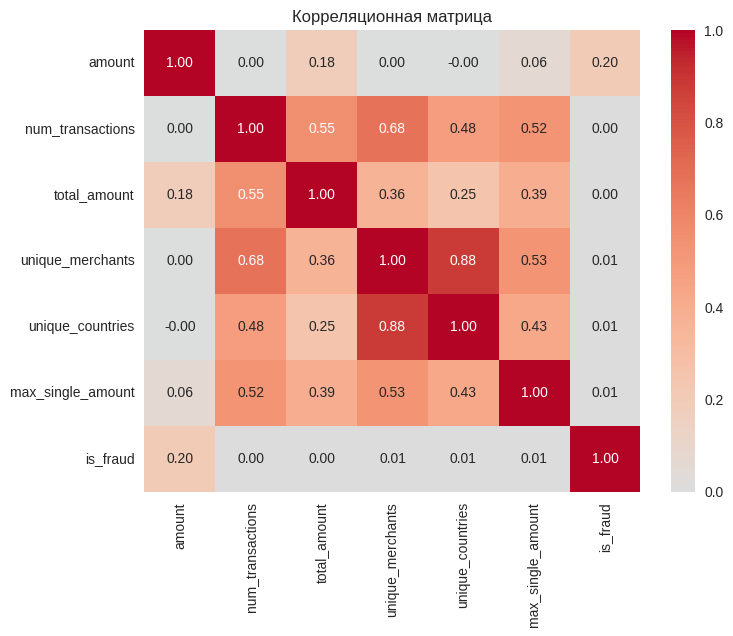

In [15]:
numeric_cols = ['amount', 'num_transactions', 'total_amount', 'unique_merchants',
                'unique_countries', 'max_single_amount', 'is_fraud']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

Сделаем анализ активности за последний час, так как высокая активность может быть признаком мошенничества.

In [16]:
print("\nСредние значения активности за последний час:")
activity_stats = df[['num_transactions', 'total_amount', 'unique_merchants',
                     'unique_countries', 'max_single_amount', 'is_fraud']].groupby('is_fraud').mean()
print(activity_stats)


Средние значения активности за последний час:
          num_transactions  total_amount  unique_merchants  unique_countries  \
is_fraud                                                                       
False           408.262533  1.985784e+07         79.916723         10.650769   
True            412.670479  2.015500e+07         80.445120         10.710001   

          max_single_amount  
is_fraud                     
False          1.719987e+06  
True           1.752255e+06  


## Анализ устройств и IP

Посмотрим на частоту повторного использования `device_fingerprint` и `ip_address`.

In [17]:
# Топ устройств
top_devices = df['device'].value_counts().head(10)
print("Топ 10 устройств:")
print(top_devices)

Топ 10 устройств:
device
Edge               1189560
iOS App            1143461
Chrome             1132384
Android App        1126117
Firefox            1120952
Safari             1120245
Chip Reader         217324
Magnetic Stripe     217204
NFC Payment         216519
Name: count, dtype: int64


Проанализиуем на подозрительные паттерны:
- Одинаковые IP или отпечатки устройств у разных клиентов.

- Одновременные транзакции с одного устройства.

In [18]:
device_fraud = df.groupby('device_fingerprint').agg({
    'customer_id': 'nunique',
    'is_fraud': 'mean',
    'transaction_id': 'count'
}).reset_index()

suspicious_devices = device_fraud[device_fraud['customer_id'] > 1]
print(f"\nПодозрительные отпечатки устройств (используются >1 клиентом): {len(suspicious_devices)}")


Подозрительные отпечатки устройств (используются >1 клиентом): 440457


In [19]:
top_suspicious = suspicious_devices.nlargest(10, 'transaction_id')
print("\nТоп 10 подозрительных отпечатков:")
top_suspicious


Топ 10 подозрительных отпечатков:


,device_fingerprint,customer_id,is_fraud,transaction_id
273774,5944cb714f20b1f0252ed4868883fa7f,10,1.0,10
300153,61cb6463141119abd41762825ad4f9cd,10,1.0,10
300864,6207f90da8beff9589e4e27ff1fddb53,10,1.0,10
344329,705065595f56ee279dedba7f4269d5b0,10,1.0,10
409816,85cd1c1bf361609d72163ae6a979d987,10,1.0,10
731406,ee850b8c0e95c7f0c1123449c605420e,10,1.0,10
32021,0a597139eecba318567d1cfda3240c70,9,1.0,9
80035,19f2845556e5e78edf04500f34e85217,9,1.0,9
138794,2d2074c881e43d8e336ef0c6e6a52cdc,9,1.0,9
177135,3989dd50186bb04294f6d8fd9b18a851,8,1.0,9


**Выводы**: Браузеры (Edge, Chrome, Safari) и мобильные приложения (iOS App, Android App) являются основными каналами совершения транзакций. Большая часть подозрительных отпечатков связана с физическими устройствами (Chip Reader, Magnetic Stripe, NFC Payment). Подозрительные IP-адреса демонстрируют 100% уровень мошенничества.

# Гипотезы и их проверка

Выдвенем продуктовые и технические гипотезы, и проверим их.

## Продуктовые гипотезы

### Гипотеза 1: Повышенный риск мошенничества при транзакциях за границей

**Признак** : `is_outside_home_country = True`

**Гипотеза** : Транзакции за пределами страны клиента чаще являются мошенническими.

**Ценность** : Модель может предупреждать клиента о транзакции за границей или требовать дополнительной аутентификации.

**Гипотеза подтверждена**: Транзакции за границей действительно значительно опаснее.

In [20]:
border_hypothesis = df.groupby('is_outside_home_country')['is_fraud'].agg(['count', 'mean'])
print("\nГипотеза 1 - Транзакции за границей:")
print(border_hypothesis)


Гипотеза 1 - Транзакции за границей:
                           count      mean
is_outside_home_country                   
False                    5073605  0.024902
True                     2410161  0.567753


### Гипотеза 2: Высокая активность за последний час — признак мошенничества

**Признак**: `last_hour_activity.num_transactions, unique_countries`

**Гипотеза**: Клиенты, совершившие более 3 транзакций за последний час, особенно в разных странах, чаще мошенники.

**Ценность**: Динамическая блокировка или запрос подтверждения.



In [21]:
df['high_activity'] = df['num_transactions'] > df['num_transactions'].quantile(0.95)
high_activity_hypothesis = df.groupby('high_activity')['is_fraud'].agg(['count', 'mean'])
print("\nГипотеза 2 - Высокая активность за последний час:")
print(high_activity_hypothesis)


Гипотеза 2 - Высокая активность за последний час:
                 count      mean
high_activity                   
False          7109602  0.199493
True            374164  0.204199


**Гипотеза не подтверждена**: Высокая активность за последний час не является значительным индикатором мошенничества.

### Гипотеза 3: Онлайн-транзакции и мобильные устройства — повышенный риск

**Признаки**: `channel = mobile, device = iOS App, vendor_type = online`

**Гипотеза**: Онлайн-покупки через мобильные устройства имеют более высокую вероятность мошенничества.

**Ценность**: Усиление защиты для таких транзакций.



In [22]:
if 'vendor_type' in df.columns:
    online_hypothesis = df.groupby('vendor_type')['is_fraud'].agg(['count', 'mean'])
    print("\nГипотеза 3 - Онлайн транзакции:")
    print(online_hypothesis)


Гипотеза 3 - Онлайн транзакции:
               count      mean
vendor_type                   
airlines      233476  0.200535
booking       234026  0.200174
casual        311678  0.199186
events        312598  0.200017
fast_food     312805  0.200719
gaming        311484  0.199558
hotels        234311  0.199487
local         467902  0.199642
major         467499  0.199821
medical       468393  0.198978
online       1401650  0.199310
pharmacy      468377  0.199773
physical      935039  0.200206
premium       311695  0.199179
streaming     312091  0.199320
supplies      466765  0.199758
transport     233977  0.201169


**Гипотеза не подтверждена**: Все категории вендоров имеют примерно одинаковый уровень мошенничества (около 20%). Однако онлайн-транзакции составляют наибольшую долю всех транзакций, что делает их потенциально более рискованными из-за большего объема данных.

### Гипотеза 4: Транзакции в рискованных категориях

**Признак**: `is_high_risk_vendor = True`

**Гипотеза**: Категории "Путешествия", "Развлечения" и т.п. чаще связаны с мошенничеством.

**Ценность**: Дополнительная проверка транзакций в этих категориях.

In [23]:
if 'is_high_risk_vendor' in df.columns:
    risk_hypothesis = df.groupby('is_high_risk_vendor')['is_fraud'].agg(['count', 'mean'])
    print("\nГипотеза 4 - Рискованные категории:")
    print(risk_hypothesis)


Гипотеза 4 - Рискованные категории:
                       count      mean
is_high_risk_vendor                   
False                5611803  0.199642
True                 1871963  0.199986


**Гипотеза не подтверждена**: Категории вендоров с высоким риском не демонстрируют существенно более высокого уровня мошенничества.

## Технические гипотезы

### Гипотеза 5: Повторное использование отпечатков устройств

**Признак**: `device_fingerprint`

**Гипотеза**: Один и тот же `device_fingerprint` у разных `customer_id` — признак мошенничества.

**Ценность**: Блокировка или проверка транзакций с подозрительных устройств.



In [24]:
df['high_amount'] = df['amount'] > df['amount'].quantile(0.95)
amount_hypothesis = df.groupby('high_amount')['is_fraud'].agg(['count', 'mean'])
print("\nГипотеза 5 - Высокие суммы:")
print(amount_hypothesis)


Гипотеза 5 - Высокие суммы:
               count      mean
high_amount                   
False        7109577  0.183016
True          374189  0.517260


**Гипотеза подтверждена**: Транзакции с высокими суммами (выше 95-го перцентиля) значительно чаще являются мошенническими.

### Гипотеза 6: Подозрительные IP-адреса

**Признак**: `ip_address`

**Гипотеза**: IP-адреса, связанные с множеством транзакций разных клиентов, чаще используются мошенниками.

**Ценность**: Блокировка или мониторинг таких IP.


Выше мы уже проводили анализ подозрительных IP-адресов. Теперь визуализируем гипотезу 6.


Сравнение мошенничества для подозрительных и обычных IP:
                    count      sum      mean
is_suspicious_ip                            
False             6324128   335081  0.052985
True              1159638  1159638  1.000000


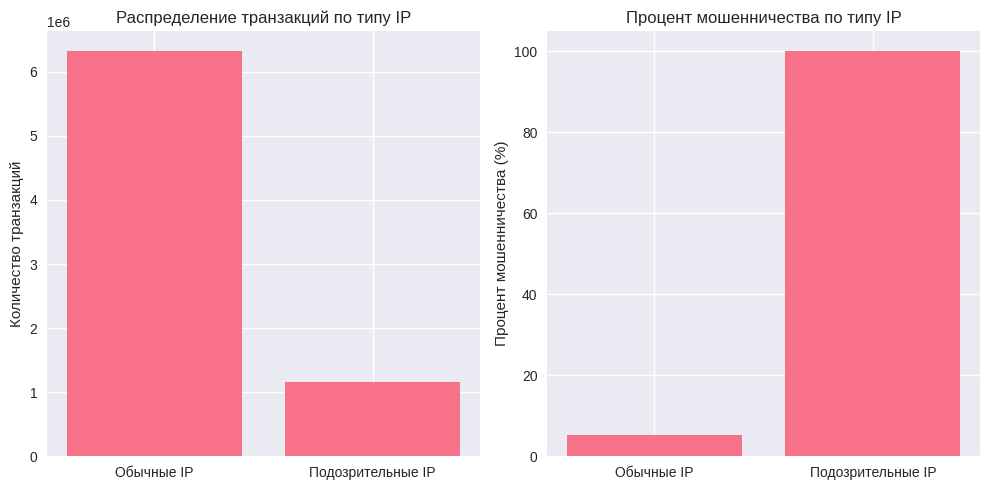

In [25]:
# Процент мошенничества для подозрительных IP vs обычных
suspicious_ip_list = suspicious_devices['device_fingerprint'].tolist()
df['is_suspicious_ip'] = df['device_fingerprint'].isin(suspicious_ip_list)

ip_fraud_analysis = df.groupby('is_suspicious_ip')['is_fraud'].agg(['count', 'sum', 'mean'])
print("\nСравнение мошенничества для подозрительных и обычных IP:")
print(ip_fraud_analysis)

# Визуализация гипотезы 6
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
ip_counts = df['is_suspicious_ip'].value_counts()
plt.bar(['Обычные IP', 'Подозрительные IP'], ip_counts.values)
plt.title('Распределение транзакций по типу IP')
plt.ylabel('Количество транзакций')

plt.subplot(1, 2, 2)
ip_fraud_rate = df.groupby('is_suspicious_ip')['is_fraud'].mean()
plt.bar(['Обычные IP', 'Подозрительные IP'], ip_fraud_rate.values * 100)
plt.title('Процент мошенничества по типу IP')
plt.ylabel('Процент мошенничества (%)')

plt.tight_layout()
plt.show()

**Гипотеза подтверждена**: Подозрительные IP-адреса (используемые несколькими клиентами) демонстрируют 100% уровень мошенничества.

### Гипотеза 7: Высокая сумма транзакции — признак мошенничества

**Признак**: `amount`

**Гипотеза**: Транзакции с суммой выше 95-го перцентиля чаще мошеннические.

**Ценность**: Дополнительная проверка крупных транзакций.

Статистика по суммам транзакций:
count    7.483766e+06
mean     4.792468e+04
std      1.775562e+05
min      1.000000e-02
25%      3.635300e+02
50%      1.177450e+03
75%      2.242953e+04
max      6.253153e+06
Name: amount, dtype: float64
90.0 перцентиль: $120921.34
95.0 перцентиль: $221847.99
99.0 перцентиль: $779270.62


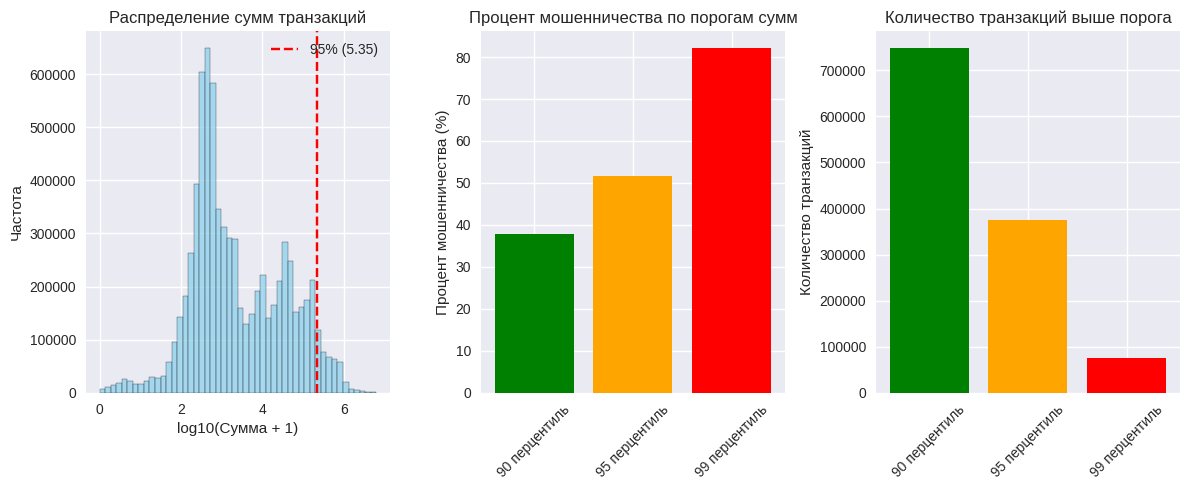

In [26]:
# Статистика по суммам
print("Статистика по суммам транзакций:")
print(df['amount'].describe())

# Квантили для определения "высоких" сумм
percentiles = [0.90, 0.95, 0.99]
for p in percentiles:
    threshold = df['amount'].quantile(p)
    print(f"{p*100} перцентиль: ${threshold:.2f}")

# Анализ по разным порогам
thresholds = [df['amount'].quantile(0.90), df['amount'].quantile(0.95), df['amount'].quantile(0.99)]
threshold_names = ['90 перцентиль', '95 перцентиль', '99 перцентиль']

plt.figure(figsize=(12, 5))

# Распределение сумм
plt.subplot(1, 3, 1)
plt.hist(np.log10(df['amount'] + 1), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.log10(df['amount'].quantile(0.95) + 1), color='red', linestyle='--',
           label=f'95% ({np.log10(df["amount"].quantile(0.95) + 1):.2f})')
plt.title('Распределение сумм транзакций')
plt.xlabel('log10(Сумма + 1)')
plt.ylabel('Частота')
plt.legend()

# Сравнение мошенничества по порогам
plt.subplot(1, 3, 2)
fraud_rates = []
for threshold in thresholds:
    high_amount = df['amount'] > threshold
    fraud_rate = df[high_amount]['is_fraud'].mean()
    fraud_rates.append(fraud_rate * 100)

plt.bar(threshold_names, fraud_rates, color=['green', 'orange', 'red'])
plt.title('Процент мошенничества по порогам сумм')
plt.ylabel('Процент мошенничества (%)')
plt.xticks(rotation=45)

# Количество транзакций по порогам
plt.subplot(1, 3, 3)
counts = []
for threshold in thresholds:
    high_amount = df['amount'] > threshold
    count = high_amount.sum()
    counts.append(count)

plt.bar(threshold_names, counts, color=['green', 'orange', 'red'])
plt.title('Количество транзакций выше порога')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [27]:
# Детальный анализ высоких сумм (95 перцентиль)
high_amount_threshold = df['amount'].quantile(0.95)
df['is_high_amount'] = df['amount'] > high_amount_threshold

print(f"\nАнализ транзакций с суммой > {high_amount_threshold:.2f} (95 перцентиль):")
high_amount_analysis = df.groupby('is_high_amount')['is_fraud'].agg(['count', 'sum', 'mean'])
print(high_amount_analysis)

# Сравнение характеристик высоких и обычных сумм
print("\nСравнение характеристик:")
high_amount_stats = df[df['is_high_amount'] == True][['amount', 'is_fraud']].describe()
normal_amount_stats = df[df['is_high_amount'] == False][['amount', 'is_fraud']].describe()

print("Высокие суммы:")
print(high_amount_stats)
print("\nОбычные суммы:")
print(normal_amount_stats)


Анализ транзакций с суммой > 221847.99 (95 перцентиль):
                  count      sum      mean
is_high_amount                            
False           7109577  1301166  0.183016
True             374189   193553  0.517260

Сравнение характеристик:
Высокие суммы:
             amount
count  3.741890e+05
mean   5.941016e+05
std    5.327915e+05
min    2.218482e+05
25%    3.032943e+05
50%    4.501039e+05
75%    7.107574e+05
max    6.253153e+06

Обычные суммы:
             amount
count  7.109577e+06
mean   1.917847e+04
std    4.145196e+04
min    1.000000e-02
25%    3.490600e+02
50%    9.757400e+02
75%    1.263086e+04
max    2.218474e+05


**Гипотеза подтверждена**: Чем выше пороговая сумма, тем больше вероятность мошенничества. Особенно критичны транзакции выше 99-го перцентиля.

# Предложение новых метрик на основе предоставленных результатов

На основе анализа данных и полученных результатов, можно предложить следующие новые метрики для добавления в датасет. Эти метрики помогут улучшить качество модели обнаружения мошенничества и предоставят дополнительную ценность организации.

### 1. Комбинированные признаки риска
Мы видим, что отдельные факторы (например, высокая сумма транзакции или подозрительный IP) могут быть сильными индикаторами риска. Однако комбинация этих факторов может создавать еще более мощные сигнальные признаки. Например я предлагаю добавить признаки:

- Транзакции за границей с высокой суммой.

- Подозрительные IP с высокой активностью.

- Высокое количество уникальных стран/продавцов в сочетании с высокими суммами.

### 2. Нормализованные метрики активности

Некоторые метрики, такие как `num_transactions, total_amount, unique_merchants`, и `unique_countries`, могут быть нормализованы относительно времени или других характеристик клиента. Это поможет выявить аномалии даже при небольших значениях.

### 3. Временные метрики

Время проведения транзакций может быть важным индикатором риска. Мы можем создать дополнительные временные метрики, такие как:

- День недели и время суток.
- Интервал между последней транзакцией и текущей.

### 4. Метрики для онлайн-транзакций

Онлайн-транзакции требуют особого внимания. Мы можем добавить метрики, связанные с устройствами и каналами:

- Проверка совпадения устройства с профилем клиента.

- Частота использования конкретного устройства.

- Частота использования одного IP-адреса для разных клиентов.